# Úkol č. 3 - Segmentace zákazníků e-shopu (do 29. listopadu)

Jednou z důležitých aplikací shlukování je **segmentace zákazníků** (angl. **customer segmentation**). 

Předpokládejme, že máme následující obchodní údaje o prodejích (resp. nákupech z pohledu zákazníků):
TransactionID - ID nákupu,
CustomerID - ID zákazníka, 
Date - datum nákupu, 
Total - celková cena nákupu.

Chceme najít segmenty zákazníků, kteří se chovají podobně. K tomu je dobré informace z jednotlivých nákupů pro individuální zákazníky agregovat. Tj. získat pro každého zákazníka jeden řádek.

Populárním přístupem je **RFM**, což znamená:

- **R**ecency: Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka).
    - Počet dnů počítejte ke dni uskutečnění poslendní transakce v celém datasetu (tj. 12/19/2015), nikoli k dnešku. Tváříme se, že jde o aktuální data.
- **F**requency: Počet nákupů. Občas se vynechávají zákazníci s jediným nákupem. Pro jednoduchost je zde ale necháme.
- **M**onetary: Celková suma, kterou daný zákazník utratil.

## Zdroj dat
Budeme pracovat s daty z jednoho (skoro) vymyšleného eshopu:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
%matplotlib inline

np.set_printoptions(precision=5, suppress=True)  # potlačení výpisu floatů (tak aby 0.000 bylo zobrazeno jako 0.)

In [2]:
df = pd.read_csv("eshop.csv")

In [3]:
display( df.head() )
display( df.tail() )
display( df.shape  )
display( df.info()   )
max(df['Subtotal'])

Customer ID       Date  Subtotal         Country
0           34  6/21/2007      86.0  Czech Republic
1           38  6/27/2007      38.4  Czech Republic
2           47   7/2/2007      53.5        Slovakia
3           61  7/14/2007       7.0  Czech Republic
4           78  7/21/2007      55.5  Czech Republic

Customer ID        Date  Subtotal         Country
22403        15356  12/18/2015     31.87  Czech Republic
22404        15357  12/18/2015      6.10  Czech Republic
22405        15358  12/18/2015    153.23  Czech Republic
22406        15359  12/19/2015     19.15  Czech Republic
22407        15360  12/19/2015    139.10  Czech Republic

(22408, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22408 entries, 0 to 22407
Data columns (total 4 columns):
Customer ID    22408 non-null int64
Date           22408 non-null object
Subtotal       22408 non-null float64
Country        22405 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 700.4+ KB


None

21001.05

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
- Vytvořte `rfm` data frame, kde každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše.
- Pomocí algoritmu `K-means` proveďte shlukování. Nějakým způsobem také odhadněte nejlepší počet shluků (podrobně vysvětlete).
- Zabývejte se vlivem přeškálování dat (standardizace příznaků). Tj. určete, zda je přeškálování vhodné, a proveďte ho.
- Interpretujte jednotlivé shluky. Použijte získané shluky k odlišení "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) od nezajímavých  zákazníků (vysoká recency, nízká frequency, nízká monetary).

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
- (až +4 body) Proveďte analýzu vytvořených shluků pomocí metody silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- (až +4 body) Zkuste provést to samé s modifikovanou verzí **RFM**, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook.
  * Ke komentování toho, co v notebooku děláte, použijte Markdown buňky.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni


***

# Transformace dat na RFM format

### Klasicka RFM

In [4]:
from datetime import date
last_day = date(2015, 12, 19)
def date_to_days ( x, modified = False ):
    d = x.split("/")
    d = date(int(d[2]), int(d[0]), int(d[1]))
    if modified:
        return max( (last_day - d).days // 30, 1)
    return (last_day - d).days

In [5]:
def get_frequency( x ):
    return len( df[df['Customer ID'] == x] )

In [6]:
# Create new DF with customer ID as index
X = df['Customer ID'].drop_duplicates()
X = pd . DataFrame(index = X)

# Add recency
X = X . merge( df . groupby('Customer ID')['Date'] . agg(min), on = 'Customer ID')
X['Date'] = X['Date'] . apply( date_to_days )

# Add Monetary
X = X . merge( 8u.groupby('Customer ID').agg(sum), on = 'Customer ID' )

# Add frequency
X = X . merge( pd . DataFrame( df.groupby('Customer ID').size(), columns = ['Frequency']), on = 'Customer ID' )
X = X . rename({'Date' : 'Recency', 'Subtotal' : 'Monetary'}, axis = 'columns')

display( max(X['Frequency']) )
display( X )
display( X.info() )

45

Recency  Monetary  Frequency
Customer ID                              
34              3103     86.00          1
38              3097     38.40          1
47              3092     53.50          1
61              3080      7.00          1
78              3073     55.50          1
...              ...       ...        ...
15356              1     31.87          1
15357              1      6.10          1
15358              1    153.23          1
15359              0     19.15          1
15360              0    139.10          1

[12829 rows x 3 columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12829 entries, 34 to 15360
Data columns (total 3 columns):
Recency      12829 non-null int64
Monetary     12829 non-null float64
Frequency    12829 non-null int64
dtypes: float64(1), int64(2)
memory usage: 400.9 KB


None

### Modifikovana RFM
Jako mesic zde povazujeme 30 dni

In [7]:
# Create dataframe where index is customer ID
X_mod = df['Customer ID'].drop_duplicates()
X_mod = pd . DataFrame(index = X_mod)

# Add Recency to dataframe
X_mod = X_mod . merge( df . groupby('Customer ID')['Date'] . agg(min) , on = 'Customer ID')
X_mod['Date'] = X_mod['Date'] . apply( date_to_days, modified = True  )

# Add Frequency to dataframe
tmp = df.copy()
tmp = tmp.drop('Country', axis = 'columns', )
tmp['Date'] = tmp['Date'].apply( date_to_days )
# Left join them
X_mod = X_mod . merge( pd . DataFrame( tmp[ tmp['Date'] < 367] . groupby('Customer ID') . size(), columns = ['Frequency']), on = 'Customer ID', how='left')
# Fill nan with 1
X_mod['Frequency'] = X_mod['Frequency'].fillna(1)
display( min(X_mod['Frequency']) )

# Add Monetary to dataframe
X_mod = X_mod . merge( df.drop(['Country', 'Date'], axis = 'columns').groupby('Customer ID').agg(max), on = 'Customer ID' )

X_mod = X_mod . rename({'Date' : 'Recency', 'Subtotal' : 'Monetary'}, axis = 'columns')
display( X_mod )
display( max( X_mod['Frequency'] ) )
# display( X_mod.info() )
# display( max(X_mod['Frequency']) )


1.0

Recency  Frequency  Monetary
Customer ID                              
34               103        1.0     86.00
38               103        1.0     38.40
47               103        1.0     53.50
61               102        1.0      7.00
78               102        1.0     55.50
...              ...        ...       ...
15356              1        1.0     31.87
15357              1        1.0      6.10
15358              1        1.0    153.23
15359              1        1.0     19.15
15360              1        1.0    139.10

[12829 rows x 3 columns]

18.0

# Visualizace dat pred normalizaci

## Klasicke RFM

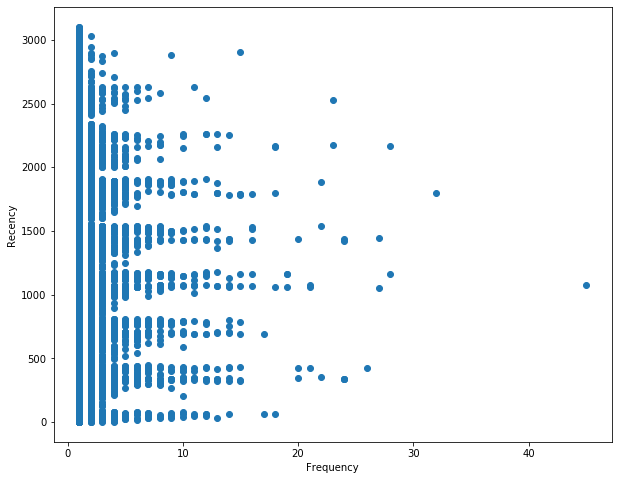

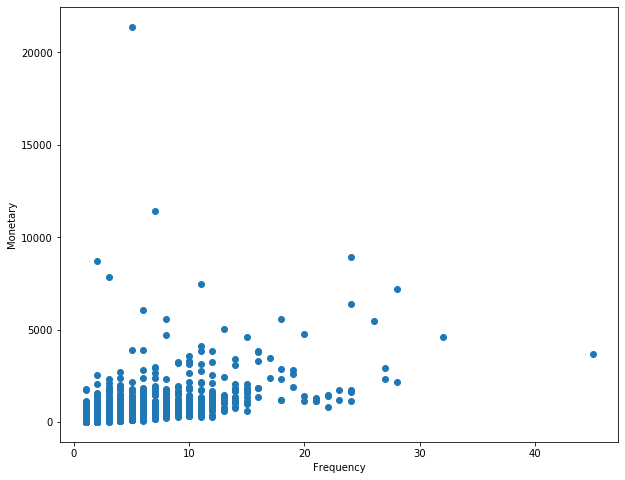

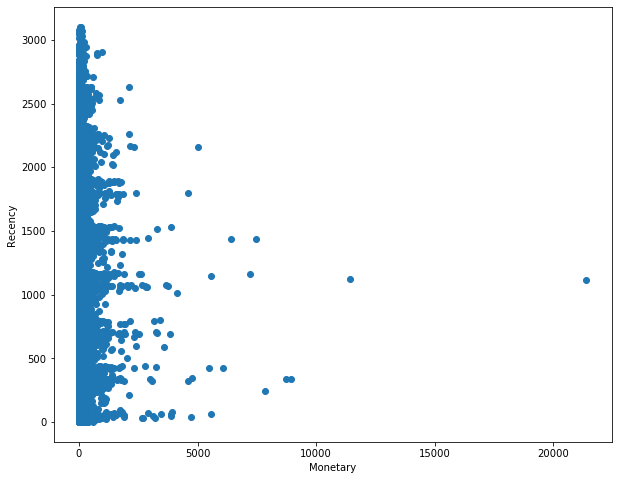

In [8]:
plt.figure(figsize=(10, 8))
ax = plt.scatter(X['Frequency'], X['Recency'])
plt.xlabel("Frequency")
plt.ylabel("Recency")
plt.show()

plt.figure(figsize=(10, 8))
plt.scatter(X['Frequency'], X['Monetary'])
plt.xlabel("Frequency")
plt.ylabel("Monetary")
plt.show()

plt.figure(figsize=(10, 8))
plt.scatter(X['Monetary'], X['Recency'])
plt.xlabel("Monetary")
plt.ylabel("Recency")
plt.show()

## Modifikovane RFM

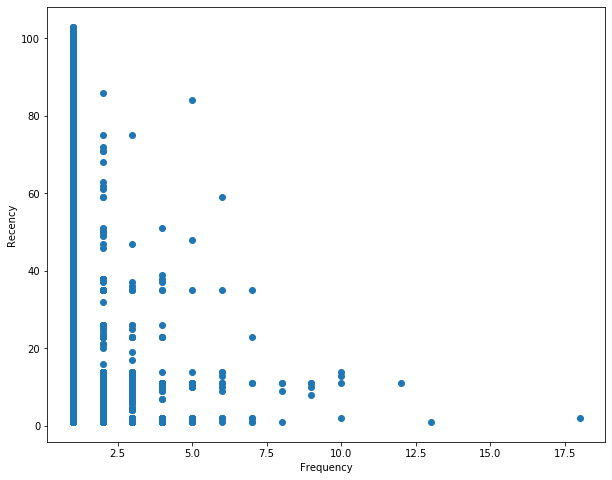

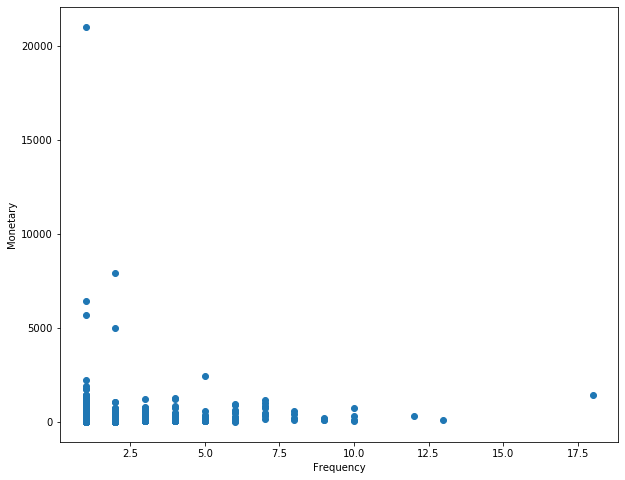

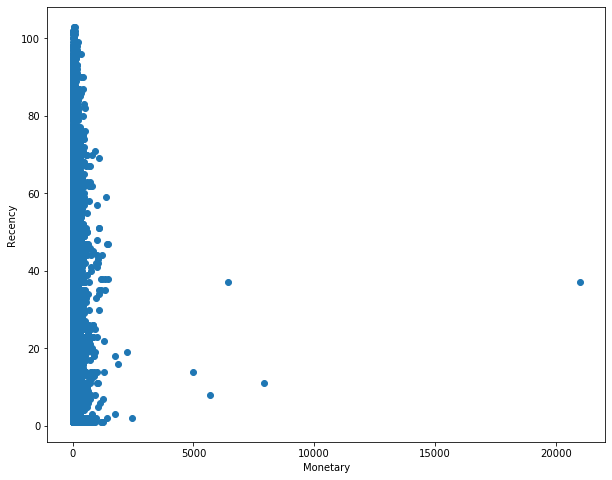

In [9]:
plt.figure(figsize=(10, 8))
ax = plt.scatter(X_mod['Frequency'], X_mod['Recency'])
plt.xlabel("Frequency")
plt.ylabel("Recency")
plt.show()

plt.figure(figsize=(10, 8))
plt.scatter(X_mod['Frequency'], X_mod['Monetary'])
plt.xlabel("Frequency")
plt.ylabel("Monetary")
plt.show()

plt.figure(figsize=(10, 8))
plt.scatter(X_mod['Monetary'], X_mod['Recency'])
plt.xlabel("Monetary")
plt.ylabel("Recency")
plt.show()

# Normalizace dat

## Je normalizace potřeba?
Normalizace dat se zde nabízí, podívejme se například na příznaky typu *frequency* a *recency*. Zřejmě nás bude zajímat, jaká je doba od posledního nákupu a jak často nakupují, takto by ale *recency* měla malou váhu v řeči metriky. Totiž, *frequency* má hodnoty nižší než 50, kdežto recency má hodnoty až 3000. Stejně tak monetary má hodnoty kolem 3000(Maximum až > 20000 !). Normalizaci tedy provedeme. 

## Provedení normalizace

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_norm = scaler . fit_transform(X)
X_norm = pd.DataFrame( X_norm, index = X.index, columns = X.columns )
display( X_norm )

scaler = StandardScaler()
X_mod_norm = scaler . fit_transform(X_mod)
X_mod_norm = pd.DataFrame( X_mod_norm, index = X_mod.index, columns = X_mod.columns )
display( X_mod_norm )


Recency  Monetary  Frequency
Customer ID                               
34           2.697712 -0.171209  -0.371483
38           2.689351 -0.287953  -0.371483
47           2.682383 -0.250919  -0.371483
61           2.665661 -0.364965  -0.371483
78           2.655907 -0.246013  -0.371483
...               ...       ...        ...
15356       -1.624867 -0.303969  -0.371483
15357       -1.624867 -0.367172  -0.371483
15358       -1.624867 -0.006320  -0.371483
15359       -1.626261 -0.335166  -0.371483
15360       -1.626261 -0.040975  -0.371483

[12829 rows x 3 columns]

Recency  Frequency  Monetary
Customer ID                               
34           2.701047  -0.170153 -0.036637
38           2.701047  -0.170153 -0.230192
47           2.701047  -0.170153 -0.168791
61           2.659213  -0.170153 -0.357873
78           2.659213  -0.170153 -0.160658
...               ...        ...       ...
15356       -1.566083  -0.170153 -0.256745
15357       -1.566083  -0.170153 -0.361533
15358       -1.566083  -0.170153  0.236740
15359       -1.566083  -0.170153 -0.308468
15360       -1.566083  -0.170153  0.179283

[12829 rows x 3 columns]

# Odhadnuti poctu shluku

### Vytvoreni shluku

In [11]:
Z = linkage( X_norm, "ward")

### Dendrogram

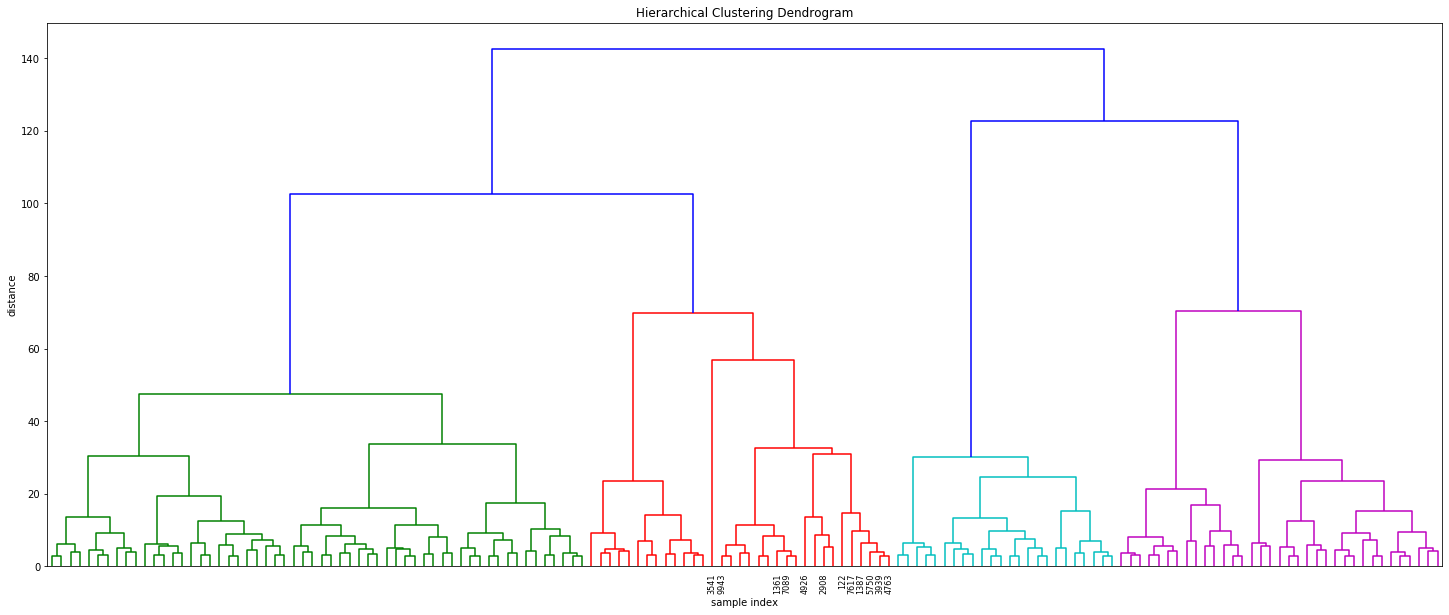

In [12]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram( Z, leaf_rotation=90., leaf_font_size=8.,truncate_mode='lastp',p=150,show_leaf_counts=False)
plt.show()

### Seknuti clusteru

In [13]:
max_distance = 82

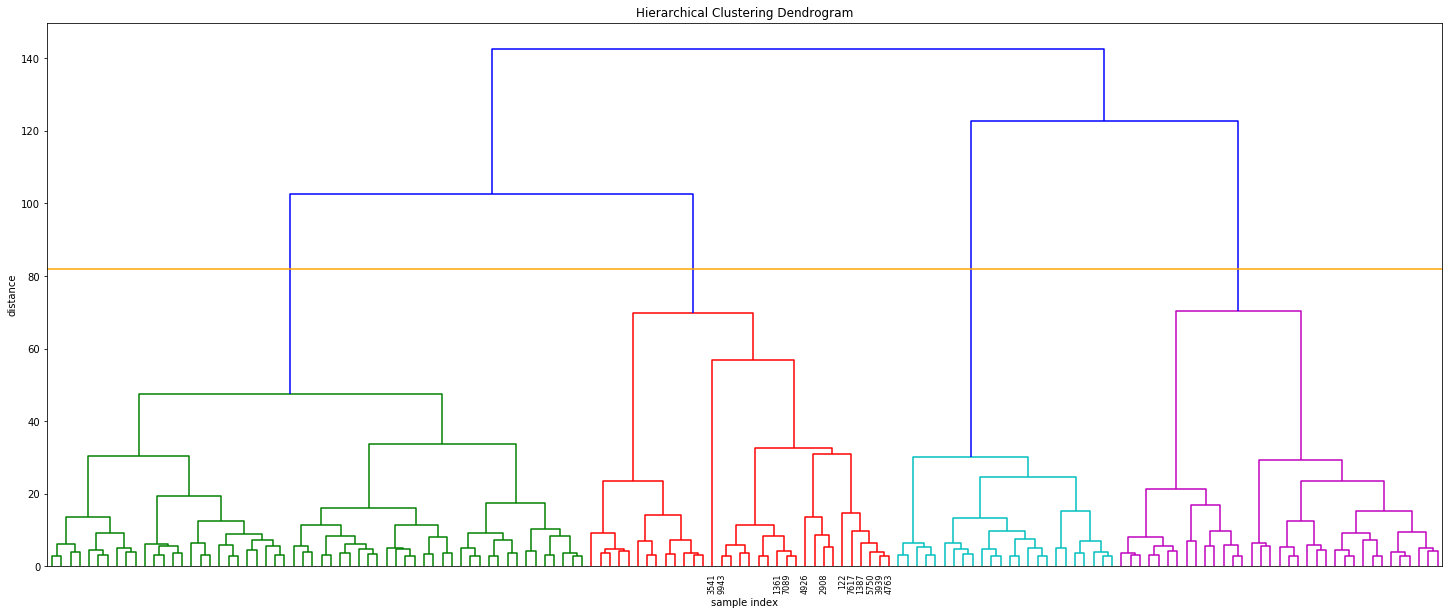

In [14]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram( Z, leaf_rotation=90., leaf_font_size=8.,truncate_mode='lastp',p=150,show_leaf_counts=False)
plt.axhline(y=max_distance, c='orange')
plt.show()

## Elbow method

### Pro normalni RFM

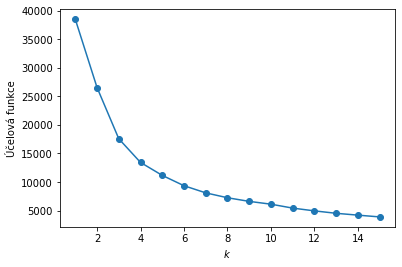

In [15]:
from sklearn.cluster import KMeans

ix = np.zeros(15)
iy = np.zeros(15)
for k in range(ix.shape[0]):
    kmeans = KMeans(n_clusters=k+1, random_state = 1)
    kmeans.fit(X_norm)
    iy[k] = kmeans.inertia_
    ix[k] = k+1

plt.xlabel('$k$')
plt.ylabel('Účelová funkce')
plt.plot(ix, iy, 'o-')
plt.show()

### Pro modifikovane RFM

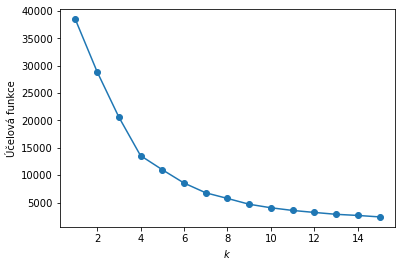

In [16]:
ix = np.zeros(15)
iy = np.zeros(15)
for k in range(ix.shape[0]):
    kmeans = KMeans(n_clusters=k+1, random_state = 1)
    kmeans.fit(X_mod_norm)
    iy[k] = kmeans.inertia_
    ix[k] = k+1

plt.xlabel('$k$')
plt.ylabel('Účelová funkce')
plt.plot(ix, iy, 'o-')
plt.show()

## Závěr pro pocty shluku
Zvolený počet shluků bude 4. U Elbow metody vidíme veliký pokles z 1 -> 2 a 2 -> 3, nabízela by se tedy 3, u modifikovane RFM metody by se ale vice nabizela 4. Z dendrogramu si myslím, ze čtyři shluky jsou docela rozumná volba, mohlo by se jich možná vzít i více, např. 7, potom už vzdálenost mezi shluky není tak veliká. Větší počet shluků by ale mohlo být na úkor interpretovatelnosti shluků. Proto jsem zvolil jen 4, takto bychom mohli dostat čtyři kategorie:
* Zákazníci, co nakoupili malokrat a za malo peněz.
* Zákazníci, co nakupují jen jednou za čas a nakupují za neextrémní množství peněz. 
* Zákazníci, co nakupují občas a za větší množství peněz.
* Zákazníci, co nakupují relativně často, pravidelní zákazníci nebo ti, co nakupují za hodně peněz, tzv. superstar zákazníci.

# Pouziti K-means

### Nestandardizovane priznaky

In [17]:
from sklearn.cluster import KMeans

k = 4
kmeans = KMeans(n_clusters = k, random_state = 1).fit(X)

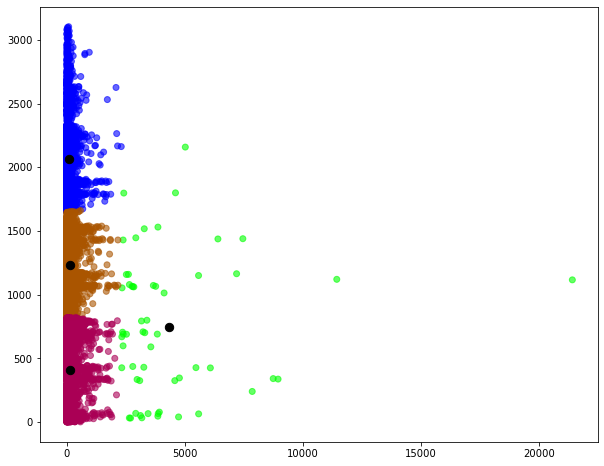

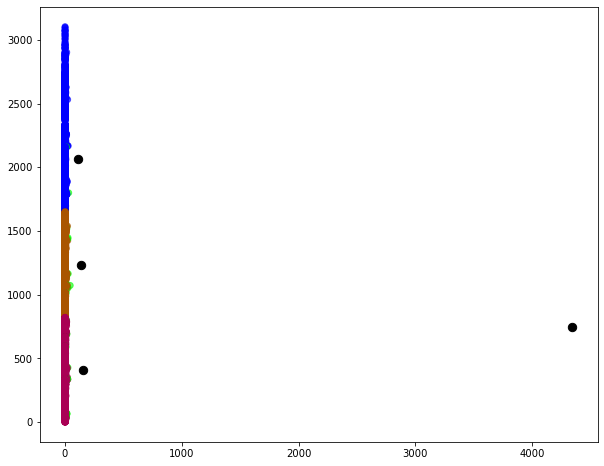

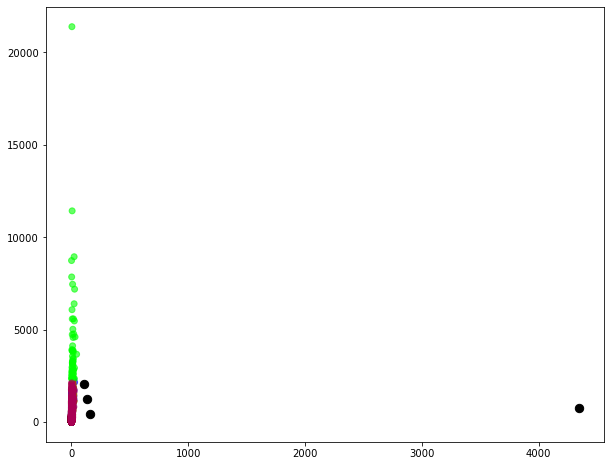

In [18]:
plt.figure(figsize=(10, 8))
plt.scatter(X['Monetary'], X['Recency'],  c=kmeans.labels_, cmap='brg', alpha=0.6)  # plot all points
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c = 'black', s=70)
plt.show()

plt.figure(figsize=(10, 8))
plt.scatter(X['Frequency'], X['Recency'],  c=kmeans.labels_, cmap='brg', alpha=0.6)  # plot all points
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c = 'black', s=70)
plt.show()

plt.figure(figsize=(10, 8))
plt.scatter(X['Frequency'], X['Monetary'],  c=kmeans.labels_, cmap='brg', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c = 'black', s=70)
plt.show()


### Standardizovane priznaky

In [19]:
from sklearn.cluster import KMeans

k = 4
kmeans = KMeans(n_clusters = k, random_state = 1).fit(X_norm)

### Standardizovane priznaky a modifikovane RFM

In [20]:
from sklearn.cluster import KMeans

k = 4
kmeans_mod = KMeans(n_clusters = k, random_state = 1).fit(X_mod_norm)

## Visualizace klusteru

### Dvojice priznaku

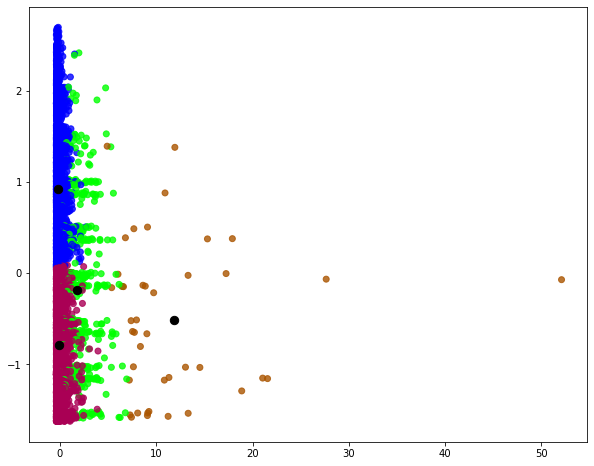

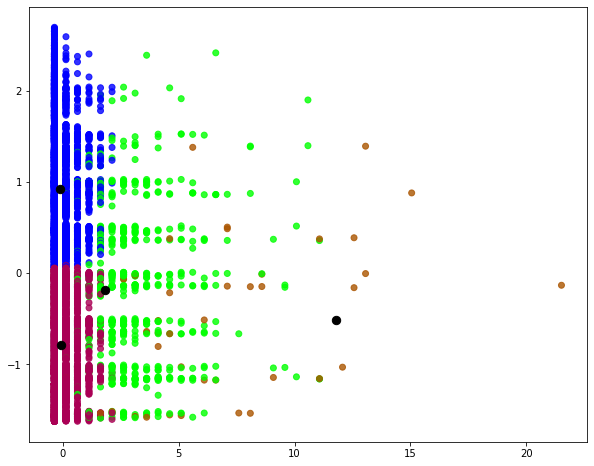

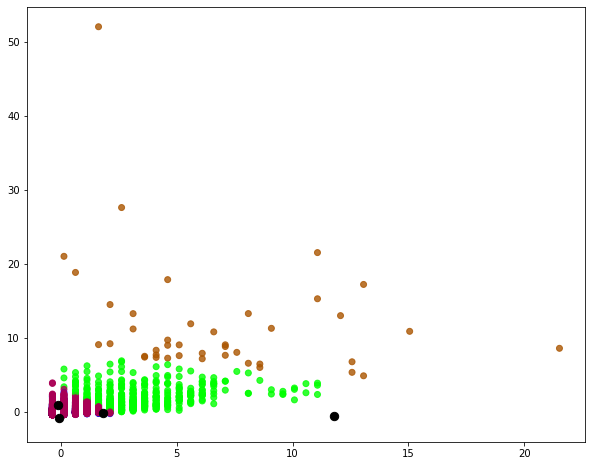

In [21]:
plt.figure(figsize=(10, 8))
plt.scatter(X_norm['Monetary'], X_norm['Recency'],  c=kmeans.labels_, cmap='brg', alpha=0.8)
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c = 'black', s=70)
plt.show()

plt.figure(figsize=(10, 8))
plt.scatter(X_norm['Frequency'], X_norm['Recency'],  c=kmeans.labels_, cmap='brg', alpha=0.8)
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c = 'black', s=70)
plt.show()

plt.figure(figsize=(10, 8))
plt.scatter(X_norm['Frequency'], X_norm['Monetary'],  c=kmeans.labels_, cmap='brg', alpha=0.8)
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c = 'black', s=70)
plt.show()

### Vsechny priznaky najednou

## Upozorneni
KMeans je zde znova vyhodnoceno, obcas se totiz stane, ze se 3D graf na prvni dobrou nevyploti. Pridani KMeans umoznuje znovu spoustet jen tuto bunku dokola dokud se graf konecne nezobrazi.

<IPython.core.display.Javascript object>


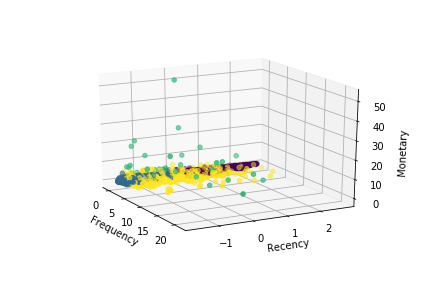

In [28]:
from sklearn.cluster import KMeans

k = 4
kmeans = KMeans(n_clusters = k, random_state = 1).fit(X_norm)

from mpl_toolkits import mplot3d
%matplotlib notebook

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X_norm['Frequency'], X_norm['Recency'], X_norm['Monetary'], c=kmeans.labels_, cmap='viridis');
ax.set_xlabel('Frequency')
ax.set_ylabel('Recency')
ax.set_zlabel('Monetary')
plt.show()


## Interpretace shluku
* Shluk nejvíce rozprostřený v prostoru jsou *superstar* zákazníci. Většina z nich nakupuje víckrát a za extrémně velké peníze (Ze 3D grafu jde toto dobře vidět, pravděpodobně není bod z jiného shluku který by byl výše než body z tohoto shluku).
* Shluk vlevo dole jsou zákazníci kteří nakupují málo, za né moc velké množství peněz.
* Shluk vlevo nahoře jsou taktéž zákazníci co nakupují málo a za málo peněz. Navíc jejich poslední nákup byl uskutečněn před dlouhou dobou.
* Shluk tvořící v grafu "zuby", jsou zákazníci, kteří nakupují celkem často, za *normální* množství peněz.  Jsou to pravidelní zákazníci

# Visualizace pro modifikovany RFM

## Dvojice priznaku

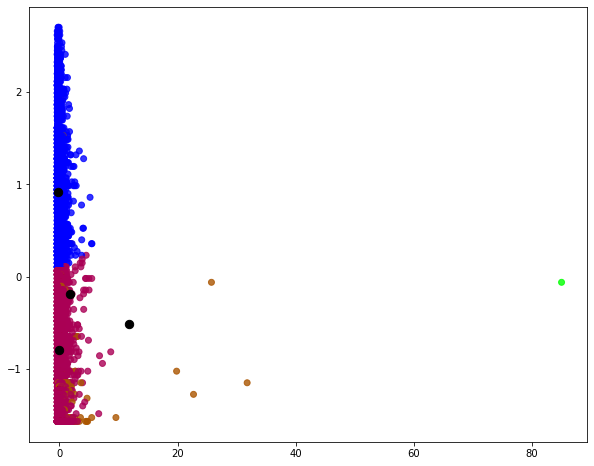

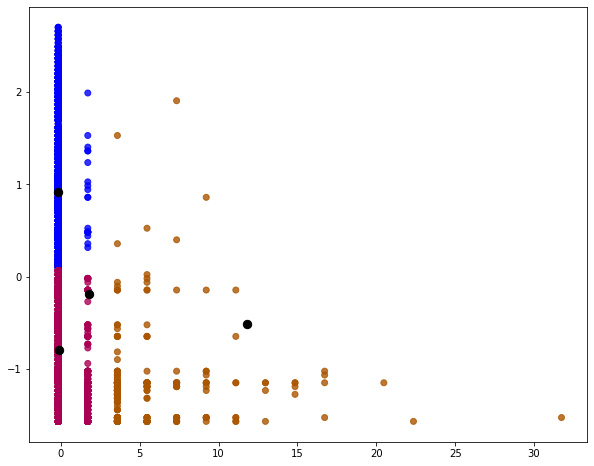

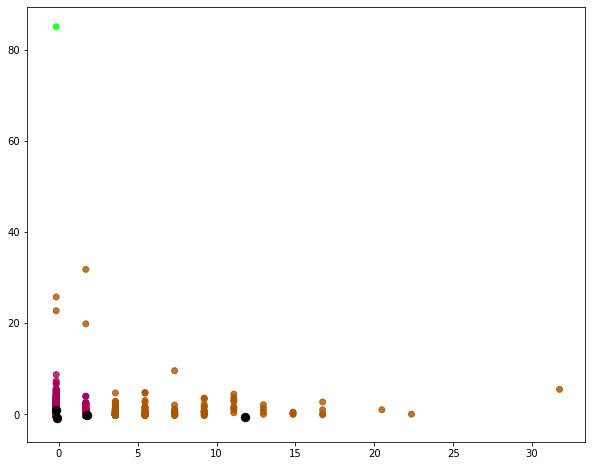

In [23]:
%matplotlib inline

plt.figure(figsize=(10, 8))
plt.scatter(X_mod_norm['Monetary'], X_mod_norm['Recency'],  c=kmeans_mod.labels_, cmap='brg', alpha=0.8)
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c = 'black', s=70)
plt.show()

plt.figure(figsize=(10, 8))
plt.scatter(X_mod_norm['Frequency'], X_mod_norm['Recency'],  c=kmeans_mod.labels_, cmap='brg', alpha=0.8)
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c = 'black', s=70)
plt.show()

plt.figure(figsize=(10, 8))
plt.scatter(X_mod_norm['Frequency'], X_mod_norm['Monetary'],  c=kmeans_mod.labels_, cmap='brg', alpha=0.8)
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c = 'black', s=70)
plt.show()

## Vsechny priznaky najednou

<IPython.core.display.Javascript object>


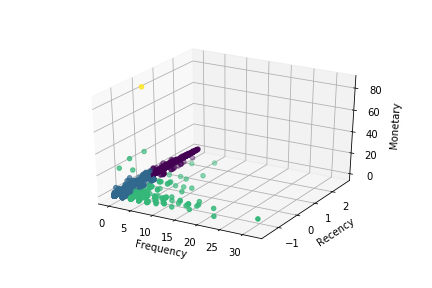

In [27]:
from sklearn.cluster import KMeans

k = 4
kmeans_mod = KMeans(n_clusters = k, random_state = 1).fit(X_mod_norm)

from mpl_toolkits import mplot3d
%matplotlib notebook

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X_mod_norm['Frequency'], X_mod_norm['Recency'], X_mod_norm['Monetary'], c=kmeans_mod.labels_, cmap='viridis');
ax.set_xlabel('Frequency')
ax.set_ylabel('Recency')
ax.set_zlabel('Monetary')
plt.show()


## Interpretace shluku
* Zde vidíme jeden shluk úplně osamostatněný, zřejmě kvůli extrémně veliké monetary value. Nachází se v něm pouze jeden zákazník. 
* Shluk vlevo dole jsou zákazníci, kteří nakupují málo za né moc velké množství peněz ale relativně nedávno.
* Shluk vlevo nahoře jsou taktéž zákazníci co nakupují málo a za málo peněz. Navíc jejich poslední nákup byl uskutečněn před dlouhou dobou.
* Poslední shluk, který je celkem rozložený v prostoru, jsou zákazníci, kteří nakupují celkem často, za *normální* množství peněz a také nakoupili relativně nedávno.

Zde nás možná trošku nepříjemně omezil jediný shluk nahoře, možná by bylo lepší navýšit počet shluků. 

In [25]:
from sklearn.cluster import KMeans

k = 6
kmeans_mod = KMeans(n_clusters = k, random_state = 1).fit(X_mod_norm)

<IPython.core.display.Javascript object>


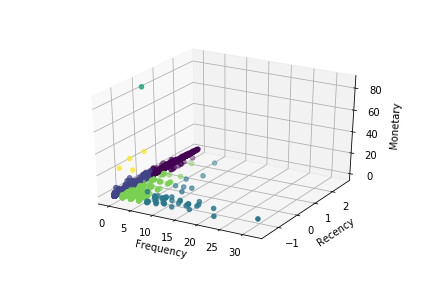

In [26]:
from mpl_toolkits import mplot3d
%matplotlib notebook

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X_mod_norm['Frequency'], X_mod_norm['Recency'], X_mod_norm['Monetary'], c=kmeans_mod.labels_, cmap='viridis');
ax.set_xlabel('Frequency')
ax.set_ylabel('Recency')
ax.set_zlabel('Monetary')
plt.show()

Vidíme, že tři shluky zůstali naprosto stejné. Další tři nám ale vznikly.
* Shluk čtyř zákazníků s vysokým monetary jsou zákazníci kteří utratily na jednom nákupu dost peněz. Moc často ale nenakupují. Zajímavé může být že tito zákazníky společně s tím, co utratil nejvíce, jsou v řeči Recency docela blízko u sebe.
* Původní shluk, kde byli lidé co nakupují častěji než ostatní, se nám rozdělil na dva
    * Shluk uprostřed reprezentuje zákazníky, kteří nenakupují zas tak často, za normální peníze a občas i před nějakou dobou
    * Shluk vpravo reprezentuje zákazníky kteří taky tolik neutrácejí, za to nakupují celkem často a nedávno.

# Závěr - RFM vs Modified RFM
Vybrání monetary jako největší utracenou částku za jeden nákup v modifikovaném RFM mi nepříjde jako moc vypovídající, verze se sumou v normálním RFM mi v tomto případě přišla lepší. Modifikované RFM podle mého názoru je lepší v tom případě, pokud chceme vidět více aktuální data díky upravené frequency. Ve výsledku, po upravení množství shluků v Modified RFM, mi přišli obě metody dobré. Obě rozdělily data do zajímavých a celkem dobře interpretovatelných shluků, netroufám si říct, která byla v tomto případě lepší. Obě přinesly užitečné poznatky. 